In [1]:
%matplotlib inline

In [2]:
import string
import math
import binascii
import functools

import gmpy as gmpy

from Crypto.Cipher import AES
from Crypto.Util import Counter

_gmpy_mpz_type = type(gmpy.mpz(0))
_gmpy_mpf_type = type(gmpy.mpf(0))


def new(K, radix):
    return FFXEncrypter(K, radix)


class Bottom(Exception):
    pass


class UnknownTypeException(Exception):
    pass


class InvalidRadixException(Exception):
    pass


def long_to_bytes(N, blocksize=1):
    """Given an input integer ``N``, ``long_to_bytes`` returns the representation of ``N`` in bytes.
    If ``blocksize`` is greater than ``1`` then the output string will be right justified and then padded with zero-bytes,
    such that the return values length is a multiple of ``blocksize``.
    """
    
    if type(N) == FFXInteger:
        return N.to_bytes()
    
    bytestring = gmpy.digits(N, 16)
    bytestring = '0' + bytestring if (len(bytestring) % 2) != 0 else bytestring
    bytestring = binascii.unhexlify(bytestring)

    if blocksize>0 and (len(bytestring) % blocksize) != 0:
        bytestring = '\x00' * \
            (blocksize - (len(bytestring) % blocksize)) + bytestring

    return bytestring

def bytes_to_long(bytestring):
    """Given a ``bytestring`` returns its integer representation ``N``.
    """
    
    N = binascii.hexlify(bytestring)
    N = gmpy.mpz(N, 16)
    
    return N


class FFXInteger(object):

    def __init__(self, x, radix=2, blocksize=None):
        _x_type = type(x)
        
        if _x_type in [_gmpy_mpz_type, int, long]:
            self._x = gmpy.digits(x, radix)
        elif _x_type in [FFXInteger]:
            self._x = x._x
        elif _x_type in [str]:
            self._x = x
        elif _x_type in [float, _gmpy_mpf_type]:
            self._x = gmpy.digits(gmpy.mpz(x), radix)
        else:
            raise UnknownTypeException(type(x))

        self._radix = radix
        if blocksize:
            self._blocksize = max(blocksize, len(self._x))
            self._x = '0' * (blocksize - len(self._x)) + self._x
        else:
            self._blocksize = len(self._x)

        self._as_bytes = None
        self._as_int = None
        self._len = None

    def __add__(self, other):
        retval = self.to_int()
        if type(other) == FFXInteger:
            retval += other.to_int()
        else:
            retval += other
        return retval

    def __sub__(self, other):
        retval = self.to_int()
        if type(other) == FFXInteger:
            retval -= other.to_int()
        else:
            retval -= other
        return retval

    def __mod__(self, other):
        retval = self.to_int()
        if type(other) == FFXInteger:
            retval %= other.to_int()
        else:
            retval %= other
        return retval

    def __eq__(self, other):
        if type(other) == FFXInteger:
            retval = self.to_int() == other.to_int()
        elif type(other) in [str]:
            retval = (self._x == other)
        elif type(other) in [int]:
            retval = (self.to_int() == other)
        elif type(other) in [type(None)]:
            retval = False
        else:
            raise UnknownTypeException()
        return retval

    def __len__(self):
        if self._len == None:
            self._len = len(self._x)
        return self._len

    def __getitem__(self, i):
        return FFXInteger(self._x[i], self._radix, 1)

    def __getslice__(self, i, j):
        return FFXInteger(self._x[i:j], self._radix, len(self._x[i:j]))

    def __str__(self):
        return self._x
    
    def __repr__(self):
        return self.to_str()

    def to_int(self):
        if not self._as_int:
            self._as_int = int(self._x, self._radix)
        return int(self._x, self._radix)

    def to_bytes(self, blocksize=None):
        if not self._as_bytes:
            if blocksize is None:
                blocksize = 1
                if self.to_int()>0:
                    blocksize = math.log(self.to_int(),2)
                blocksize /= 8
                blocksize = math.ceil(blocksize)
                blocksize = int(blocksize)
            self._as_bytes = long_to_bytes(self.to_int(), blocksize=blocksize)
        return self._as_bytes

    def to_str(self):
        return self._x


class FFXEncrypter(object):

    def __init__(self, K, radix):
        if radix not in range(2, 26 + 26 + 10 + 1):
            raise InvalidRadixException()

        self._radix = gmpy.mpz(radix)
        self._chars = string.digits + string.ascii_lowercase
        self._chars = self._chars[:radix]
        _chars = []
        for c in self._chars:
            _chars.append(c)
        self._chars = _chars

        self._K = K
        self._ecb = AES.new(K, AES.MODE_ECB)
        self._P = {}

    def isEven(self, n):
        return not ((n & 0x1) == 1)

    def add(self, X, Y):
        retval = (X + Y) % (X._radix ** (X._blocksize))
        return FFXInteger(retval, radix=self._radix, blocksize=X._blocksize)

    def sub(self, X, Y):
        retval = (X - Y) % (X._radix ** (X._blocksize))
        return FFXInteger(retval, radix=self._radix, blocksize=X._blocksize)

    #def rnds(self, n):
    #    return 10

    def split(self, n):
        """TODO"""
        return int(math.floor((n * 1.0) / 2))

    def F(self, n, T, i, B):
        if T == 0:
            t = 0
        else:
            t = len(T)

        beta = math.ceil(n / 2.0)
        b = int(math.ceil(beta * math.log(self._radix, 2) / 8.0))
        d = 4 * int(math.ceil(b / 4.0))

        if self.isEven(i):
            m = int(math.floor(n / 2.0))
        else:
            m = int(math.ceil(n / 2.0))

        if not self._P.get(n):
            P = '\x01'  # vers
            P += '\x02'  # method
            P += '\x01'  # addition
            P += long_to_bytes(self._radix, 3)
            P += '\x0a' # always ten
            P += long_to_bytes(self.split(n)%256, 1)
            P += long_to_bytes(n, 4)
            P += long_to_bytes(t, 4)
            self._P[n] = P

        if T == 0:
            Q = ''
        else:
            Q = str(T)
            
        Q += '\x00' * (((-1 * t) - b - 1) % 16)
        Q += long_to_bytes(i, blocksize=1)
        
        _B_as_bytes = long_to_bytes(B)
        Q += '\x00' * (b - len(_B_as_bytes))
        Q += _B_as_bytes

        _cbc = AES.new(self._K, AES.MODE_CBC, '\x00' * 16)
        Y = _cbc.encrypt(self._P[n] + Q)[-16:]

        i = 1
        TMP = Y
        while len(TMP) < (d + 4):
            left = FFXInteger(bytes_to_long(Y), radix=self._radix, blocksize=32)
            right = FFXInteger(str(i), radix=10, blocksize=16)
            X = self.add(left, right)
            TMP += self._ecb.encrypt(X.to_bytes(16))
            i += 1

        y = bytes_to_long(TMP[:(d + 4)])
        z = y % (self._radix ** m)

        return z

    def encrypt(self, T, X):
        retval = ''

        n = len(X)
        l = self.split(n)
        r = 10 #self.rnds(n)
        A = X[:l]
        B = X[l:]
        for i in range(r):
            C = self.add(A, self.F(n, T, i, B))
            A = B
            B = C

        retval = FFXInteger(str(A) + str(B), radix=self._radix)
        
        return retval

    def decrypt(self, T, Y):
        retval = ''
        
        n = len(Y)
        l = self.split(n)
        r = 10 #self.rnds(n)

        A = Y[:l]
        B = Y[l:]
        for i in range(r - 1, -1, -1):
            C = B
            B = A
            A = self.sub(C, self.F(n, T, i, B))
            
        retval = FFXInteger(str(A) + str(B), radix=self._radix)

        return retval

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import misc
from scipy import ndimage

# This function is for convert 0 to 1 -> 0 to 255 values and its string representation of bit
# Eg. input: 1 -> 255 -> output: '11111111'
def color_to_string(value):
    value = int(value * 255.0)
    bin8 = lambda x : ''.join(reversed( [str((x >> i) & 1) for i in range(8)] ))
    return bin8(value)

# This function is for convert bit string to integer
def string_to_color(str_value):
    return int(str_value, 2)

Image dimension is  4
Total number of pixel:  1024
Encryption done


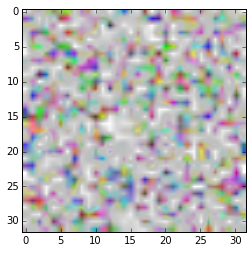

Image dimension is  4
Total number of pixel:  1024


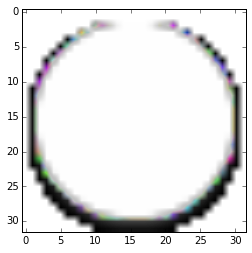

In [10]:
image = mpimg.imread("test22.png")
height = image.shape[0]
width = image.shape[1]
dimension = len(image[0][0])
print "Image dimension is ", dimension
print "Total number of pixel: ", width * height
# Key is in string format of 16 bytes = 128 bit key for AES
K = '012F' * 8 
ffxObj = new('0000'*8,radix=2)
# Tweak parameter
T = FFXInteger('0'*8,radix=2, blocksize=8)

plain_text = ''
for j in range(0, height):
    for i in range(0, width):
        # print j*width + i
        # print "image , ", image[j][i]
        for k in image[j][i]:
            plain_text += color_to_string(k)
X =  FFXInteger(plain_text,radix=2, blocksize=8)
X = ffxObj.encrypt(T, X)
for j in range(0, height):
    for i in range(0, width):
         image[j][i] = [string_to_color(str(X[0:8])),string_to_color(str(X[8:16])),string_to_color(str(X[16:24])), string_to_color(str(X[24:32]))]
         X = X[32:]
print "Encryption done"

plt.imshow(image)
misc.imsave('encrypt.png', image)
plt.show()

image = mpimg.imread('encrypt.png')

height = image.shape[0]
width = image.shape[1]
dimension = len(image[0][0])
print "Image dimension is ", dimension
print "Total number of pixel: ", width * height
# Key is in string format of 16 bytes = 128 bit key for AES
# Tweak parameter
T = FFXInteger('0'*8,radix=2, blocksize=8)
# Message
# X = FFXInteger(color_to_string(255),radix=2, blocksize=4)
# C = ffxObj.encrypt(T, X)
# Y = ffxObj.decrypt(T, C)
plain_text = ''
for j in range(0, height):
    for i in range(0, width):
        for k in image[j][i]:
            plain_text += color_to_string(k)
Y = FFXInteger(plain_text,radix=2, blocksize=8)
Y = ffxObj.decrypt(T, Y)
for j in range(0, height):
    for i in range(0, width):
        image[j][i] = [string_to_color(str(Y[0:8])),string_to_color(str(Y[8:16])),string_to_color(str(Y[16:24])), string_to_color(str(Y[24:32]))]
        Y = Y[32:]
print "Decryption done"

plt.imshow(image)
misc.imsave('decrypt.png', image)
plt.show()